In [1]:
# 1. Imports
import os
import yaml
import pickle
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patheffects as pe
from shapely.geometry import box
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# 2. Utility Functions

def load_config(path="config.yaml"):
    with open(path) as f:
        return yaml.safe_load(f)

def load_base_tiles(processed_dir):
    with open(os.path.join(processed_dir, "all_tiles_without_roads.pkl"), "rb") as f:
        df_base = pickle.load(f).reset_index(drop=True)
    df_base = df_base[df_base['mean_elev_m'] <= 350].reset_index(drop=True)
    return df_base

def load_lidar_inventory(lidar_csv_path, crs="EPSG:3857"):
    li = pd.read_csv(lidar_csv_path)
    li_gdf = gpd.GeoDataFrame(
        li,
        geometry=li.apply(lambda r: box(r.min_lon, r.min_lat, r.max_lon, r.max_lat), axis=1),
        crs="EPSG:4326"
    ).to_crs(crs)
    return li_gdf

def mark_lidar_coverage(df_base, li_gdf):
    gdf_base = gpd.GeoDataFrame(df_base, geometry='geometry', crs='EPSG:3857')
    lidar_union = li_gdf.geometry.union_all()
    df_base['lidar_cover'] = gdf_base.geometry.intersects(lidar_union)
    return df_base

def encode_country_region(df):
    df_enc = pd.get_dummies(
        df,
        columns=['country', 'region'],
        prefix=['country', 'region']
    )
    return df_enc

def compute_spatial_groups(df_enc, n_bins=5):
    gdf_enc = gpd.GeoDataFrame(df_enc, geometry='geometry', crs='EPSG:3857')
    centroids = gdf_enc.geometry.centroid.to_crs('EPSG:4326')
    df_enc['lon'], df_enc['lat'] = centroids.x, centroids.y
    df_enc['lon_bin'] = pd.qcut(df_enc['lon'], q=n_bins, labels=False, duplicates='drop')
    df_enc['lat_bin'] = pd.qcut(df_enc['lat'], q=n_bins, labels=False, duplicates='drop')
    df_enc['spatial_group'] = df_enc['lon_bin'] * n_bins + df_enc['lat_bin']
    return df_enc

def downsample(df, neg_ratio=2, seed=42):
    pos = df[df['has_geoglyph'] == 1]
    neg = df[df['has_geoglyph'] == 0].sample(len(pos) * neg_ratio, random_state=seed)
    return pd.concat([pos, neg]).sample(frac=1, random_state=seed)

def plot_lidar_splits(df_base, li_gdf, regions, train_df, val_df, test_df):
    # AOI
    aoi_union = gpd.GeoDataFrame(df_base, geometry=df_base.geometry, crs='EPSG:3857').unary_union
    li_sub = li_gdf.to_crs('EPSG:3857')[li_gdf.intersects(aoi_union)]
    # Regions as dissolved polygons
    region_polys = (
        gpd.GeoDataFrame(df_base, geometry=df_base.geometry, crs='EPSG:3857')
          .dissolve(by='region')
          .reset_index()
    )
    # All splits
    all_splits = pd.concat([train_df, val_df, test_df], ignore_index=True)
    actual = all_splits.loc[all_splits['has_geoglyph'] == 1].copy()
    actual = gpd.GeoDataFrame(actual, geometry=actual.geometry_point, crs='EPSG:3857')
    pred = all_splits.loc[all_splits['pred_prob'] > 0.5].copy()
    pred = gpd.GeoDataFrame(pred, geometry=pred.geometry_point, crs='EPSG:3857')

    fig, ax = plt.subplots(figsize=(12, 10))
    li_sub.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=5, alpha=0.7, label='LiDAR coverage')
    region_polys.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2, linestyle='--', label='Region bounds')
    for _, row in region_polys.iterrows():
        x, y = row.geometry.centroid.coords[0]
        ax.text(x, y, row['region'], fontsize=14, fontweight='bold', ha='center', va='center',
                path_effects=[pe.withStroke(linewidth=3, foreground="white")])
    gpd.GeoDataFrame(train_df, geometry=train_df.geometry, crs='EPSG:3857') \
        .plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5, label='Train tiles')
    gpd.GeoDataFrame(val_df, geometry=val_df.geometry, crs='EPSG:3857') \
        .plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1.5, linestyle='--', label='Val tiles')
    actual.plot(ax=ax, marker='o', color='orange', markersize=100, alpha=0.8, label='Actual geoglyphs')
    pred.plot(ax=ax, marker='x', color='limegreen', markersize=100, alpha=0.9, label='Predicted geoglyphs')
    handles = [
        mlines.Line2D([], [], color='red', linewidth=5, label='LiDAR coverage'),
        mlines.Line2D([], [], color='black', linewidth=2, linestyle='--', label='Region bounds'),
        mlines.Line2D([], [], color='black', linewidth=1.5, label='Train tiles'),
        mlines.Line2D([], [], color='blue', linewidth=1.5, linestyle='--', label='Val tiles'),
        mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=10, label='Actual geoglyphs'),
        mlines.Line2D([], [], color='limegreen', marker='x', linestyle='None', markersize=12, label='Predicted geoglyphs'),
    ]
    ax.legend(handles=handles, fontsize=12, framealpha=0.7, loc='upper right')
    ax.set_title("LiDAR + Region bounds + Train/Val/Test splits + Actual vs Predicted", fontsize=16)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

def get_final_predictions(gdf_all, li_gdf, proba_thresh=0.5):
    # Tiles with pred_prob > 0.5
    tiles_pred = gpd.GeoDataFrame(
        gdf_all[gdf_all['pred_prob'] >proba_thresh].copy(),
        geometry='geometry',
        crs='EPSG:3857'
    )
    # Spatial join with LiDAR polygons
    joined = gpd.sjoin(
        tiles_pred,
        li_gdf[['filename', 'geometry', 'max_lat', 'min_lat', 'max_lon', 'min_lon']],
        how='inner',
        predicate='intersects'
    )
    # Unique tile_id ↔ filename
    result = (
        joined[['tile_id','split','n_geoglyphs','filename', 'geometry', 'max_lat', 'min_lat', 'max_lon', 'min_lon']]
          .drop_duplicates(subset=['tile_id','filename'])
          .reset_index(drop=True)
    )
    result['centroid'] = result.geometry.centroid
    result_wgs = result.to_crs('EPSG:4326')
    result_wgs['lon'] = result_wgs.centroid.x
    result_wgs['lat'] = result_wgs.centroid.y
    final = result_wgs[['tile_id','split','n_geoglyphs','filename','lon','lat','max_lat','min_lat', 'max_lon', 'min_lon']]
    return final



In [2]:
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
# 0. Load config and paths
config = load_config()
PROCESSED_DIR = config["processed_data_dir"]
RAW_DIR = config["raw_data_dir"]
lidar_csv = os.path.join(RAW_DIR, "datasets/cms_brazil_lidar_tile_inventory.csv")

# 1. Load data
df_base = load_base_tiles(PROCESSED_DIR)
li_gdf = load_lidar_inventory(lidar_csv)

# 2. Mark LiDAR coverage
df_base = mark_lidar_coverage(df_base, li_gdf)

# 3. Encode country and region
df_enc = encode_country_region(df_base)

# 4. Compute spatial groups
df_enc = compute_spatial_groups(df_enc, n_bins=5)

# 5. Feature list
base_num = [
    'drainage_density','dist_to_mountain_m','dist_to_river_m',
    'mean_elev_m','mean_slope_deg','ord_flow','upland_skm','drainage_density_m',
    'tri','twi','curv_plan','curv_prof',
    'clay_0_5cm','ph_h2o_0_5cm','soc_0_5cm',
    'PC1','PC2','PC3','PC4','PC5','PC6','PC7'
]
FEATURES = [c for c in base_num if c in df_enc.columns]

# 6. Split by LiDAR
test_df = df_enc[df_enc['lidar_cover']].reset_index(drop=True)
rem_df  = df_enc[~df_enc['lidar_cover']].reset_index(drop=True)

# 7. 80/20 train/val split (stratified by has_geoglyph)
rem_train, rem_val = train_test_split(
    rem_df,
    test_size=0.2,
    stratify=rem_df['has_geoglyph'],
    random_state=42  # FIXED
)

# 8. Downsample negatives (1:2)
train_df = downsample(rem_train, neg_ratio=2, seed=42)  # FIXED
val_df   = downsample(rem_val,   neg_ratio=2, seed=42)  # FIXED

# Save split labels for later
train_df['split'] = 'train'
val_df  ['split'] = 'val'
test_df ['split'] = 'test'

# 9. Prepare data for modeling
X_train, y_train = train_df[FEATURES], train_df['has_geoglyph']
groups           = train_df['spatial_group']
X_val,   y_val   = val_df[FEATURES],   val_df['has_geoglyph']
X_test,  y_test  = test_df[FEATURES],  test_df['has_geoglyph']


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.794531	valid_0's binary_logloss: 0.475288
Fold 1 ROC AUC: 0.6079
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[106]	valid_0's auc: 0.884844	valid_0's binary_logloss: 0.366839
Fold 2 ROC AUC: 0.6636
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[69]	valid_0's auc: 0.886484	valid_0's binary_logloss: 0.367811
Fold 3 ROC AUC: 0.5250
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[99]	valid_0's auc: 0.854297	valid_0's binary_logloss: 0.391299
Fold 4 ROC AUC: 0.4451
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[82]	valid_0's auc: 0.874219	valid_0's binary_logloss: 0.374793
Fold 5 ROC AUC: 0.3932
OOF ROC AUC: 0.6058
Training until validation scores don't improve for 30 rounds
[10

/tmp/ipykernel_545/2724690077.py:70: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  aoi_union = gpd.GeoDataFrame(df_base, geometry=df_base.geometry, crs='EPSG:3857').unary_union


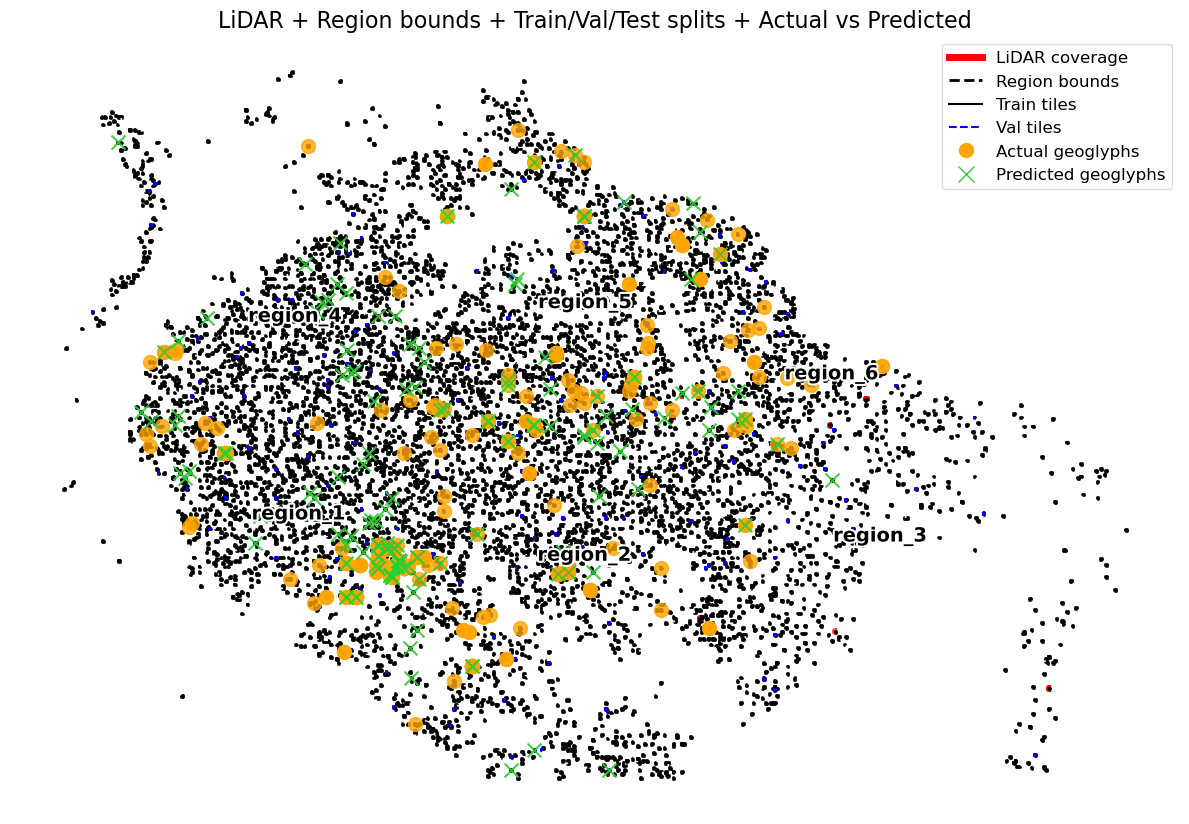

In [3]:
# 10. Out-of-fold GroupKFold OOF + callbacks
lgb_params = dict(
    n_estimators=150,
    is_unbalance=True,
    random_state=42,
    reg_alpha=1.0,
    reg_lambda=1.0,
    min_gain_to_split=0.01,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    verbosity=-1,
)

oof = np.zeros(len(train_df))
gkf = GroupKFold(n_splits=5)
for fold, (tr_idx, te_idx) in enumerate(gkf.split(X_train, y_train, groups), start=1):
    clf = lgb.LGBMClassifier(
       **lgb_params
    )
    clf.fit(
        X_train.iloc[tr_idx], y_train.iloc[tr_idx],
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[early_stopping(stopping_rounds=30), log_evaluation(period=0)]
    )
    preds = clf.predict_proba(X_train.iloc[te_idx])[:, 1]
    oof[te_idx] = preds
    print(f"Fold {fold} ROC AUC: {roc_auc_score(y_train.iloc[te_idx], preds):.4f}")
print(f"OOF ROC AUC: {roc_auc_score(y_train, oof):.4f}")

# 11. Final model & evaluation
final_clf = lgb.LGBMClassifier(
       **lgb_params
)
final_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[early_stopping(stopping_rounds=30), log_evaluation(period=10)]
)
val_preds  = final_clf.predict_proba(X_val)[:, 1]
test_preds = final_clf.predict_proba(X_test)[:, 1]
print(f"Validation ROC AUC: {roc_auc_score(y_val, val_preds):.4f}")
print(f"Test       ROC AUC: {roc_auc_score(y_test, test_preds):.4f}")

# 12. Feature importances
fi = pd.DataFrame({
    'feature': final_clf.booster_.feature_name(),
    'importance': final_clf.feature_importances_
})
fi['importance_pct'] = 100 * fi['importance'] / fi['importance'].sum()
fi = fi.sort_values('importance_pct', ascending=False).reset_index(drop=True)
print("\nFeature importances:")
print(fi.to_string(index=False, formatters={'importance_pct':'{:6.2f}%'.format}))

# 13. Assign predictions for visualization
train_df['pred_prob'] = oof
val_df  ['pred_prob'] = val_preds
test_df ['pred_prob'] = test_preds

# 14. Visualization
plot_lidar_splits(df_base, li_gdf, None, train_df, val_df, test_df)

In [4]:
# 15. Export prediction matches with LiDAR tiles
df_all = pd.concat([train_df, val_df, test_df], ignore_index=True)
gdf_all = gpd.GeoDataFrame(df_all, geometry=df_all.geometry, crs='EPSG:3857')
final = get_final_predictions(gdf_all, li_gdf, proba_tresh=0.5)
print(final.head(3))


Empty DataFrame
Columns: [tile_id, split, n_geoglyphs, filename, lon, lat, max_lat, min_lat, max_lon, min_lon]
Index: []


In [6]:
out_csv = os.path.join(PROCESSED_DIR, "/predicted_tiles_with_lidar.csv")
final.to_csv(out_csv, index=False)
print("Saved:", out_csv)

Saved: /predicted_tiles_with_lidar.csv
